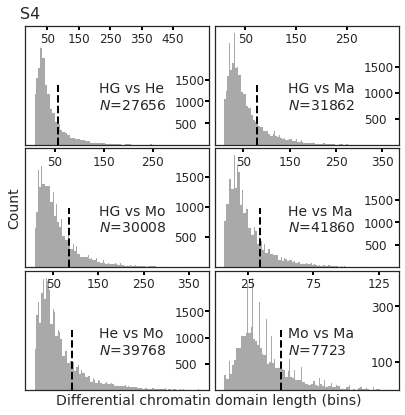

In [1]:
%matplotlib inline

import os as os
import collections as col
import itertools as itt
import pickle as pck
import time as ti
import json as js

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import numpy as np
import numpy.random as rng
import scipy.stats as stats
import pandas as pd
import seaborn as sns

# What does this do?
# Plot a histogram of the HSP length
# distribution (intended for merged HSPs)
date = '20180921'

run_plot_hsp_length_dist = True

save_figures = True
diss_version = False

journal = 'bmc_genbio'
res = 'print_lo'
fig_sizes = js.load(open('/home/pebert/work/code/mpggit/statediff/annotation/misc/fig_sizes.json'))
fig_sizes = fig_sizes[journal]
resolution = fig_sizes['resolution']

scorings = ['penem', 'ordem', 'penrep', 'ordrep']
segmentations = ['cmm18', 'ecs18', 'ecs10']

sns.set(style='white',
        font_scale=1.5,
        rc={'font.family': ['sans-serif'],
            'font.sans-serif': ['DejaVu Sans']})

fhgfs_base = '/TL/deep/fhgfs/projects/pebert/thesis/projects/statediff'
cache_dir = os.path.join(fhgfs_base, 'caching/notebooks')

data_root = os.path.join(fhgfs_base, 'sciddo', 'deep')

base_out = '/TL/epigenetics2/work/pebert/cloud/mpiinf/phd/chapter_projects/statediff'
fig_supp = os.path.join(base_out, 'figures', 'pub', 'supp')
fig_main = os.path.join(base_out, 'figures', 'pub', 'main')
fig_collect = os.path.join(base_out, 'figures', 'pub', 'collection')
fig_diss = '/home/pebert/work/code/mpggit/dissertation/Figures/diffchrom'
                   
    
def collect_hsp_data(rootfolder):
    collector = col.defaultdict(list)
    for root, dirs, datafiles in os.walk(rootfolder):
        if root.endswith('hsp_run'):
            for df in datafiles:
                # sciddo-run_hg38_cmm18_penem_HG_vs_He.h5
                infos = df.split('.')[0].split('_')
                seg = infos[2]
                score = infos[3]
                c1, c2 = infos[4], infos[6]
                fpath = os.path.join(root, df)
                with pd.HDFStore(fpath, 'r') as hdf:
                    for k in hdf.keys():
                        if k.startswith('/segments'):
                            data = hdf[k]
                            data = data.loc[data['segment_expect'] < 1, :].copy()
                            sizes = data['num_bins'].values.tolist()
                            collector[(seg, score, c1, c2)].extend(sizes)
    return collector
    

def create_histogram(data, segment, scoring, fkey, save_diss):
    """
    """
    subset = dict([(k,v) for k,v in data.items() if segment in k and scoring in k and 'Liver' not in k])
    assert len(subset) == 6, 'Missing: {}'.format(subset.keys())
    fig, axes = plt.subplots(figsize=fig_sizes['two_col']['square'],
                             nrows=3, ncols=2, sharex=False, sharey=False)
    
    plt.subplots_adjust(wspace=0.03, hspace=0.03)
    
    ax_idx = itt.product([0, 1, 2], [0, 1])
    for key, (row, col) in zip(sorted(subset.keys()), ax_idx):
        ax = axes[row, col]
        sub_data = np.array(subset[key], dtype=np.int32)
        plot_label = '{} vs {}\n$N$={}'.format(key[2], key[3], sub_data.size)
        upper_limit = np.percentile(sub_data, 97.5)
        pct75 = np.percentile(sub_data, 75)
        sub_data = sub_data[sub_data < upper_limit]
        n, bins, patches = ax.hist(sub_data, bins=100, color='darkgrey',
                                   histtype='stepfilled', zorder=0,
                                   label=plot_label)

        y_max = min(1501, max([a.max() for a in n]))
        if y_max == 1501:
            y_start = 500
            y_step = 500
            y_pad = -35
        elif y_max > 100:
            y_start = 100
            y_step = 200
            y_pad = -28
        else:
            y_start = 20
            y_step = 20
            y_pad = -22
        y_ticks = np.arange(y_start, y_max, step=y_step)
        
        x_max = min(900, max(bins))
        if x_max > 800:
            x_start = 100
            x_step = 300
        elif x_max > 300:
            x_start = 50
            x_step = 100
        else:
            x_start = 25
            x_step = 50
        x_ticks = np.arange(x_start, x_max, step=x_step)
        
        ax.text(x=0.4, y=0.3, s=plot_label,
                fontdict={'fontsize': 14},
                transform=ax.transAxes)
        
        ax.tick_params(axis='both', direction='in', which='both',
                       width=2, length=4, color='black',
                       labelsize=12,
                       bottom=False, labelbottom=False,
                       right=True, labelright=True,
                       top=True, labeltop=True,
                       left=False, labelleft=False)
        
        ax.set_xticks(x_ticks)
        ax.set_yticks(y_ticks)
        
        ax.xaxis.set_tick_params(pad=-20)
        ax.yaxis.set_tick_params(pad=y_pad)
        
        ax.axvline(pct75, ymin=0, ymax=0.5,
                   linestyle='dashed', lw=2,
                   color='black', zorder=3)
        
        if (row, col) == (0, 0) and not save_diss:
            tt = ax.set_title(fkey, fontsize=16)
            tt.set_position((0.025, 1.01))
            
        if (row, col) == (2, 0):
            xlab = ax.set_xlabel('Differential chromatin domain length (bins)', fontsize=14)
            xlab.set_position((1., -0.1))
        
        if (row, col) == (1, 0):
            ylab = ax.set_ylabel('Count', fontsize=14)

    if save_diss:
        exart = [xlab, ylab]
    else:
        exart = [tt, xlab, ylab]
            
    return fig, exart
        
    
            
def plot_hsp_length_dist():
    cache_file = os.path.join(cache_dir, '{}_plot_hsp_lendist.pck'.format(date))
    if not os.path.isfile(cache_file):
        sizes = collect_hsp_data(data_root)
        with open(cache_file, 'wb') as cache:
            pck.dump(sizes, cache)
    else:
        with open(cache_file, 'rb') as cache:
            sizes = pck.load(cache)
            
    for seg in segmentations:
        if seg != 'cmm18':
            continue
        for score in scorings:
            if score != 'penem':
                continue
            fk = 'S4'
            fig, exart = create_histogram(sizes, seg, score, fk, diss_version)
            
            if save_figures:
                outname = 'fig_{}_hsp_lendist_{}_{}'.format(fk, seg, score)
                if diss_version:
                    out_folder = fig_diss
                else:
                    out_folder = fig_supp
                
                out_pdf = os.path.join(out_folder, outname + '.pdf')
                fig.savefig(out_pdf, bbox_inches='tight', extra_artists=exart)
                
                if not diss_version:
                    out_png = os.path.join(out_folder, outname + '.png')
                    fig.savefig(out_png, bbox_inches='tight', extra_artists=exart, dpi=resolution[res])
    return 0
     
    
if run_plot_hsp_length_dist:
    plot_hsp_length_dist()
